# Trainining and Validation Datasets & losses

Prepare de dataset for training 
Calculate losses


Process:

- Tokenize the datasets
- Divide datasets into "chunks" os user specified sizes
- shuffle the rows and organize batches 
- this will be fed to the training process

In [1]:
import torch
import myllm.gpt as gpt
import myllm.data as data
import tiktoken


In [2]:
# initializations

tokenizer = tiktoken.get_encoding("gpt2")

# to reduce complexity for trainig
gpt_config = gpt.GPT_CONFIG_124M
gpt_config["context_length"] = 256 # reduced to faster training
model = gpt.GPTModel(gpt_config)

In [3]:
# load vocabulary for learning purposes

file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("chars", total_characters)
print("tokens", total_tokens)

chars 20479
tokens 5145


In [4]:
# Generate both sets
train_ratio = 0.9 # 90% train / 10% validation
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [5]:
torch.manual_seed(123)

train_loader = data.create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=gpt_config["context_length"],
    stride=gpt_config["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = data.create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=gpt_config["context_length"],
    stride=gpt_config["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0 
)

print("Train loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nValidation:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation:
torch.Size([2, 256]) torch.Size([2, 256])


In [6]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [7]:
# compute training and validation loss
#1 Iteratives over all batches if no fixed num_batches is specified 
#2 Reduces the number of batches to match the total number of batches in the data loader if num_batches exceeds the number of batches in the data loader 
#3 Sums loss for each batch 
#4 Averages the loss over all batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if (len(data_loader)) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [8]:
# In action
# Determine to which compute unit to send
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

# approaching zero is a good thing
print("Training: ", train_loss)
print("Validation: ", val_loss)

Training:  10.971639633178711
Validation:  11.02949333190918


# Simple Traininig of a LLM Model
A typical training loop for training deep neural networks in PyTorch consists of numerous steps, iterating over the batches in the training set for several epochs. In each loop, we calculate the loss for each training set batch to determine loss gradients, which we use to update the model weights so that the training set loss is minimized.

From the book

In [9]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # evaluation step not training
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = gpt.GPTModel.text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = gpt.GPTModel.generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, content_size=context_size
        )
    decoded_text = gpt.GPTModel.token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

### Main Training Loop

In [10]:

def train_model_simple(model, train_loader, val_loader, 
                        optimizer, device, num_epochs,
                        eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0,-1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (step {global_step:06d}): "
                      f"Train loss {train_loss: .3f}"
                      f"Val loss {val_loss: .3f}"
                      )
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen

In [11]:
# Fire in the hole!

torch.manual_seed(123)

model = gpt.GPTModel(gpt_config)
model.to(device)

# common practice in Deep Learning is using an optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (step 000000): Train loss  9.778Val loss  9.927
Ep 1 (step 000005): Train loss  8.115Val loss  8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (step 000010): Train loss  6.665Val loss  7.044
Ep 2 (step 000015): Train loss  5.960Val loss  6.614
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (step 000020): Train loss  5.656Val loss  6.551
Ep 3 (step 000025): Train loss  5.360Val loss  6.370
Every effort moves you know parcel KokAPS public Patterns MuseAPS coral dying Forgottenznapesocyte. Gisburn, and's centresI stationed, and left Gisburn, and I had been saw Mrs. Gisburn, andburn, and Mrs. Gis
Ep 4 (step 000030): Train loss  5.099Val loss  6.328
Ep 4 (step 000035): Train loss  4.517Val loss  6.285
Every effort moves you know it's"I had been.                                          
Ep 5 (step 000040): Train loss  4.104Val loss  6.164
Every effo

### Plotting the Results
give me light!

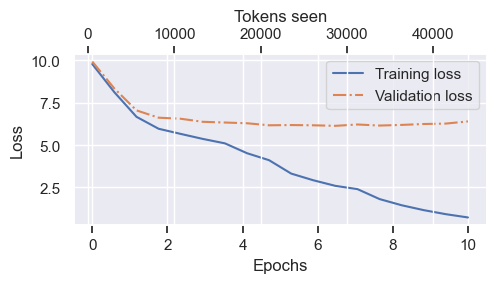

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set()


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                   #1
    ax2.plot(tokens_seen, train_losses, alpha=0)     #2
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)